# Deep Learning på vindatasættet

Målet er at opbygge et neuralt netværk med Tensorflow og Keras til klassifikation af vinene i vindatasættet.

In [244]:
# Import af biblioteker
import setuptools
import tensorflow
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping
from keras.metrics import categorical_accuracy
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


### Indledende databehandling

Vi indlæser vindatasættet, fjerner kolonnen 'Id' og opsplitter i uafhængige variable (egenskaberne ved vinen), _X_ og afhængige variabel (vinkvaliteten), _y_.

Herefter normaliserer vi _X_ og one hot encoder _y_.

In [245]:
df = pd.read_csv('WineQT.csv')
df.drop(columns=['Id'], inplace=True)
X = df.drop(columns=['quality'])
y = df['quality']

In [246]:
X = MinMaxScaler().fit_transform(X)
y = LabelEncoder().fit_transform(y)
y = to_categorical(y, 6)

### Opbygning af modellen

Vi opbygger en sequential model, hvor vi kan vælge antallet af "Dense" lag og graden af "Droput" i input.

In [247]:
def build_model(no_layers=2, dropout=0.2, activation_type='relu',):
    model = Sequential()
    for i in range(no_layers):
        if i == 0:
            model.add(Dense(np.power(2, no_layers + 4 - i), input_dim=11, activation=activation_type))
        else:
            model.add(Dense(np.power(2, no_layers + 4 - i), activation=activation_type))
        if dropout > 0:
            model.add(Dropout(dropout))
    model.add(Dense(6, activation='softmax'))
    return model

In [248]:
def compile_model(model, loss='categorical_crossentropy', metric='categorical_accuracy'):
    model.compile(optimizer=Adam(), loss=loss, metrics=[metric])
    return model

In [249]:
def train(model, X, y):
    callbacks = [
        # EarlyStopping: Stop med at træne modellen, når den marginale forbedring bliver tilpas lille
        keras.callbacks.EarlyStopping(
            min_delta = 0.005,
            patience = 10,
            monitor = 'val_loss',
            mode = 'min',
            restore_best_weights = True
        ),
    ]
    return model.fit(
        X,
        y,
        epochs = 300,
        verbose = 0,
        validation_split = 0.2,
        callbacks = callbacks
    )

### Test af modellen

Der er nogle ting, som vi kan ændre i modellen, for at se, om vi kan opnå en højere accuracy score.

Vi kan f.eks. ændre på (ordforklaringer fra https://keras.io/api/layers/ indsat):

- Antal lag i den sekventielle model ("Layers are the basic building blocks of neural networks in Keras. A layer consists of a tensor-in tensor-out computation function (the layer's call me"))

- Graden af dropout  ("The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Inputs not set to 0 are scaled up by 1 / (1 - rate) such that the sum over all inputs is unchanged.")

- Typen af aktiveringsfunktion i de enkelte lag (der er mange forskellige muligheder, hvoraf vi har valgt tre nedenfor)

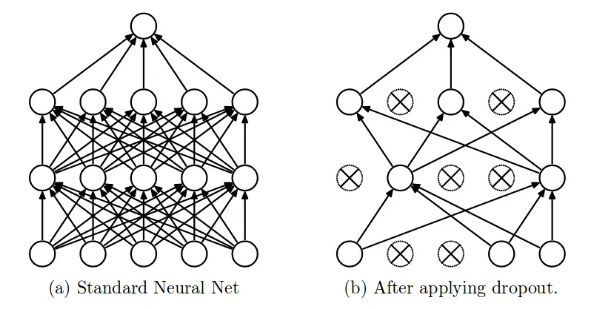

In [267]:
no_layers = [2, 3, 4, 5, 6]
dropouts = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
act_types = ['relu', 'sigmoid', 'tanh']
combs = list(itertools.product(no_layers, dropouts, act_types))

In [268]:
test_results = pd.DataFrame(columns=['no_layers', 'dropout', 'activation', 'accuracy'])
test_results = test_results.head(0)

Vi afprøver de $5\cdot 6\cdot 3=180$ forskellige kombinationer og gemmer resultaterne i en Pandas DataFrame.

In [ ]:
for no_layers, dropout, act_type in combs:
    model = build_model(no_layers, dropout, act_type)
    model = compile_model(model)
    train(model, X, y)
    acc = model.evaluate(X, y)[1]
    params = {'no_layers': no_layers, 'dropout': dropout, 'activation': act_type, 'accuracy': acc}
    test_results.loc[len(test_results)] = params

In [271]:
test_results.sort_values(by='accuracy', ascending=False).head()

,no_layers,dropout,activation,accuracy
60,5,0.2,relu,0.644794
78,6,0.2,relu,0.643045
54,5,0.0,relu,0.642170
21,3,0.1,relu,0.640420
51,4,0.5,relu,0.639545


In [272]:
test_results.sort_values(by='accuracy', ascending=False).tail()

,no_layers,dropout,activation,accuracy
25,3,0.2,sigmoid,0.404199
73,6,0.0,sigmoid,0.404199
40,4,0.1,sigmoid,0.404199
43,4,0.2,sigmoid,0.404199
55,5,0.0,sigmoid,0.404199


Ud fra vores test af modellen kan vi konkludere følgende med nogenlunde sikkerhed:

- Det betyder rigtig meget for modellens accuracy, hvordan den er sat sammen (vi får resultater fra ca. 40% til ca 64%).

- Vi har ikke fundet en kombination, som kan måle sig med den bedste af de mere simple metoder (se arket med random forests)


Vi kan ikke sige meget om:

- Kunne vi sammensætte en model, som præsterer endnu bedre?

- Er det de mest relevante parametre, vi har ændret på?